<a href="https://colab.research.google.com/github/4lerman/sentiment_classification/blob/main/Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install tensorflow[and-cuda] transformers pandas beautifulsoup4 matplotlib plotly wordcloud scikit-learn

In [3]:
# !pip install tensorflow==2.15.0 keras==2.15.0 tf-keras

In [4]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=current_folder,
    extract=True,
)


84125825/84125825 [==============================] - 5s 0us/step


In [6]:
dataset_path = os.path.dirname(dataset)

os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [7]:
dataset_dir = os.path.join(dataset_path, "aclImdb")

os.listdir(dataset_dir)

['test', 'imdb.vocab', 'imdbEr.txt', 'train', 'README']

In [8]:
train_dir = os.path.join(dataset_dir, "train")

os.listdir(train_dir)

['unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'pos']

In [9]:
for curr_file in os.listdir(train_dir):
  file_path = os.path.join(train_dir, curr_file)

  if os.path.isfile(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
      first_value = f.readline().strip()
      print(f'{curr_file}: {first_value}')
  else:
    print(f'{curr_file}: {file_path}')

unsup: /content/datasets/aclImdb/train/unsup
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 217:1 230:1 255:1 321:5 343:1 357:1 370:1 390:2 468:1 514:1 571:1 619:1 671:1 766:1 877:1 1057:1 1179:1 1192:1 1402:2 1416:1 1477:2 1940:1 1941:1 2096:1 2243:1 2285:1 2379:1 2934:1 2938:1 3520:1 3647:1 4938:1 5138:4 5715:1 5726:1 5731:1 5812:1 8319:1 8567:1 10480:1 14239:1 20604:1 22409:4 24551:1 47304:1
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1

In [10]:
def load_dataset(directory):
  data = {"sentence" : [], "sentiment": []}
  for file_name in os.listdir(directory):
    print(file_name)
    if file_name == "pos":
      positive_dir = os.path.join(directory, file_name)
      for text_file in os.listdir(positive_dir):
        text_path = os.path.join(positive_dir, text_file)
        with open(text_path, 'r', encoding="utf-8") as f:
          data["sentence"].append(f.read())
          data["sentiment"].append(1)
    elif file_name == "neg":
      negative_dir = os.path.join(directory, file_name)
      for text_file in os.listdir(negative_dir):
        text_path = os.path.join(negative_dir, text_file)
        with open(text_path, 'r', encoding="utf-8") as f:
          data["sentence"].append(f.read())
          data["sentiment"].append(0)

  return pd.DataFrame.from_dict(data)

In [11]:
train_df = load_dataset(train_dir)
print(train_df.head())

unsup
labeledBow.feat
unsupBow.feat
urls_neg.txt
urls_unsup.txt
urls_pos.txt
neg
pos
                                            sentence  sentiment
0  Bad acting. Bad writing. This was a poorly wri...          0
1  You do realize that you've been watching the E...          0
2  I think I laughed twice. The line where the ma...          0
3  Richard Tyler is a little boy who is scared of...          0
4  This movie was on the Romance channel, and I t...          0


In [12]:
test_dir = os.path.join(dataset_dir, "test")

test_df = load_dataset(test_dir)
print(test_df.head())

labeledBow.feat
urls_neg.txt
urls_pos.txt
neg
pos
                                            sentence  sentiment
0  I saw this film purely based on the fact that ...          0
1  L'Auberge Espagnole is less funny and less int...          0
2  How in the world does a thing like this get in...          0
3  Despite a small handful of nicely executed sce...          0
4  Somehow, this documentary about Miles manages ...          0


In [13]:
sentiment_counts = train_df["sentiment"].value_counts()

fig = px.bar(x={0:"Negative", 1: "Positive"},
             y=sentiment_counts.values,
             color=sentiment_counts.index,
             color_discrete_sequence=px.colors.qualitative.Dark24,
             title='<b>Sentiment Counts</b>')

fig.update_layout(
    title={'text': "<b>Sentiment Counts</b>",},
    xaxis_title="Sentiment",
    yaxis_title="Count",
    template="plotly_dark"
)

fig.show()
pyo.plot(fig, filename='sentiment_counts.html', auto_open=True)

'sentiment_counts.html'

In [14]:
def text_cleaning(text):
  soup = BeautifulSoup(text, "html.parser")
  text = re.sub(r'\[[^]]*\]', '', soup.get_text())
  pattern = r"[^a-zA-Z0-9\s,']"
  text = re.sub(pattern, '', text)
  return text

In [15]:
train_df["cleaned_sentence"] = train_df['sentence'].apply(text_cleaning).tolist()
test_df["cleaned_sentence"] = test_df['sentence'].apply(text_cleaning).tolist()

In [16]:
def generate_wordcloud(text, title):
  all_text = " ".join(text)
  wc = WordCloud(width=800,
                 height=400,
                 stopwords=set(STOPWORDS),
                 background_color='black').generate(all_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(title)
  plt.show()

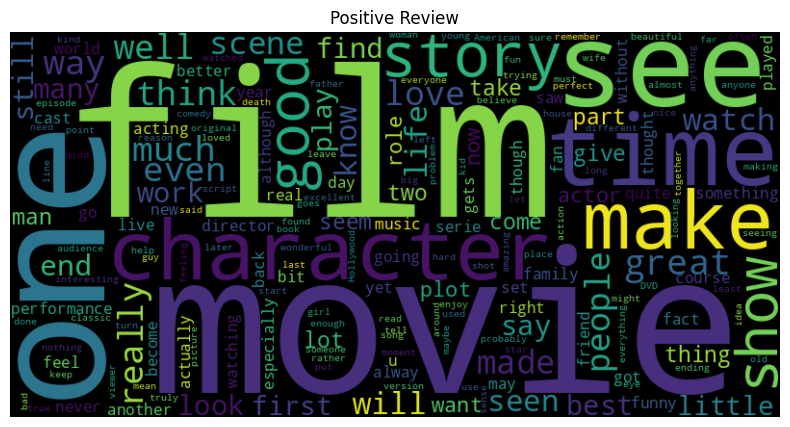

In [17]:
positive = train_df[train_df['sentiment'] == 1]['cleaned_sentence'].tolist()
generate_wordcloud(positive, "Positive Review")

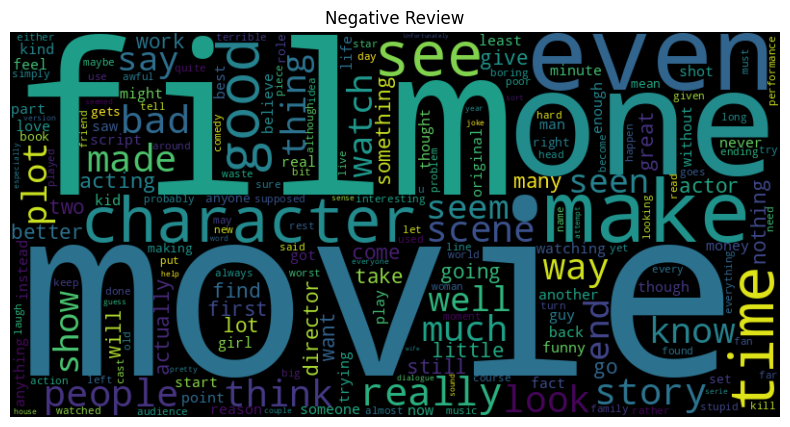

In [18]:
negative = train_df[train_df['sentiment'] == 0]['cleaned_sentence'].tolist()
generate_wordcloud(negative, "Negative Review")

In [19]:
Reviews = train_df['cleaned_sentence']
Target = train_df['sentiment']

test_reviews = test_df['cleaned_sentence']
test_targets = test_df['sentiment']

In [20]:
x_val, x_test, y_val, y_text = train_test_split(test_reviews, test_targets, test_size=0.5, stratify=test_targets)

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
max_len=128
x_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length=max_len,
                                              return_tensors='tf')

x_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length=max_len,
                                              return_tensors='tf')

x_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length=max_len,
                                              return_tensors='tf')

In [23]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',x_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(x_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',x_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Bad acting Bad writing This was a poorly written film It's too bad because it had some potential It's not even close to American Pie or Something about Mary as previous comments might have you believe Rent it at dollar night from you local video store if you're kind of bored

Input Ids -->>
 tf.Tensor(
[  101  2919  3772  2919  3015  2023  2001  1037  9996  2517  2143  2009
  1005  1055  2205  2919  2138  2009  2018  2070  4022  2009  1005  1055
  2025  2130  2485  2000  2137 11345  2030  2242  2055  2984  2004  3025
  7928  2453  2031  2017  2903  9278  2009  2012  7922  2305  2013  2017
  2334  2678  3573  2065  2017  1005  2128  2785  1997 11471   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

In [24]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
history = model.fit(
    [x_train_encoded['input_ids'], x_train_encoded['token_type_ids'],
     x_train_encoded['attention_mask']],
    Target,
    validation_data=(
        [x_val_encoded['input_ids'], x_val_encoded['attention_mask'],
         x_val_encoded['token_type_ids']], y_val),
    batch_size=32,
    epochs=3,
)

Epoch 1/3
782/782 [==============================] - 789s 992ms/step - loss: 0.3263 - accuracy: 0.8580 - val_loss: 0.2648 - val_accuracy: 0.8907
Epoch 2/3
782/782 [==============================] - 773s 989ms/step - loss: 0.1940 - accuracy: 0.9228 - val_loss: 0.2984 - val_accuracy: 0.8882
Epoch 3/3
782/782 [==============================] - 773s 988ms/step - loss: 0.1002 - accuracy: 0.9638 - val_loss: 0.3553 - val_accuracy: 0.8797


In [29]:
test_loss, test_accuracy = model.evaluate(
    [x_test_encoded['input_ids'], x_test_encoded['attention_mask'],
     x_test_encoded['token_type_ids']], y_text
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 108s 276ms/step - loss: 0.3564 - accuracy: 0.8789
Test loss: 0.35640081763267517, Test accuracy: 0.8788800239562988


In [30]:
path = '/content'

tokenizer.save_pretrained(path + "/Tokenizer")

model.save_pretrained(path + "/Model")

In [31]:
bert_tokenizer = BertTokenizer.from_pretrained(path + "/Tokenizer")
bert_model = TFBertForSequenceClassification.from_pretrained(path + "/Model")

Some layers from the model checkpoint at /content/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [33]:
pred = bert_model.predict(
    [x_test_encoded['input_ids'], x_test_encoded['attention_mask'],
     x_test_encoded['token_type_ids']])

logits = pred.logits

pred_labels = tf.argmax(logits, axis=1)

pred_labels = pred_labels.numpy()

label = {
    1 : "positive",
    0 : "negative"
}

pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_text]

print("Predicted Label: ", pred_labels[:10])
print("Actual Label: ", Actual[:10])

391/391 [==============================] - 109s 279ms/step
Predicted Label:  ['negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive']
Actual Label:  ['negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive']


In [34]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.83      0.87      6250
    positive       0.85      0.93      0.88      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



In [37]:
def get_sentiment(review, tokenizer=bert_tokenizer, model=bert_model):
  if not isinstance(review, list):
    review = [review]

  input_ids, token_type_ids, attention_mask = tokenizer.batch_encode_plus(review,
                              padding=True,
                              truncation=True,
                              max_length=128, return_tensors='tf').values()

  prediction = model.predict([input_ids, attention_mask, token_type_ids])

  pred_labels = tf.argmax(prediction.logits, axis=1)
  pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
  return pred_labels

In [41]:
review = '''M. Night Shyamalan’s The Happening is a thriller that fails to thrill. Despite an intriguing premise—nature striking back against humanity—the film stumbles with awkward dialogue, wooden performances, and unintentionally comedic moments. Mark Wahlberg and Zooey Deschanel struggle with bizarrely written characters, making it hard to take the story seriously. The suspense feels forced, and the plot unravels into absurdity rather than mystery. What could have been a chilling environmental horror ends up as a baffling misfire.'''

get_sentiment(review)

1/1 [==============================] - 0s 79ms/step


['negative']